# Inference (with `sklearn`)

In [1]:
from formulaic import Formula
import fastreg as fr
import fastreg.general as frg
from fastreg import I, R, C
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
from tools import visual

## `sklearn` Basics

Most `sklearn` models have a standardized interface. An estimator will have a `fit` method that takes `X` and `y` in the form of arrays. Once you've estimated the model, you can also use the `predict` method that takes `X` values and returns predicted `y` values. Certain estimators, especially classifiers, will have a combined `fit_predict` method that does both in a single step.

This library wont do a lot of specification work for you and expects numeric arras (sometimes called "design matrices"). However, it does have a lot of preprocessing capabilities for numerical data. To get from something like a `pandas` DataFrame to numeric arrays, you'll need an intermediate library. Some options include `patsy`, `formulaic`, and my very own `fastreg`. In fact, `formulaic` is in some sense the evolution of `patsy`, so you might want to stick with that.

First let's generate some fake data to play with.

In [6]:
N = 10
data = pd.DataFrame({
    'x1': np.arange(N),
    'x2': np.random.rand(N)
})
data['y'] = 1 + 2*data['x1'] + 3*data['x2'] + np.random.randn(N)

We can generate design matrices by creating a `Formula` object with an R (or "Wilkinson") style formula specification that references the columns of `data`. We then apply that to our DataFrame yielding a design matrix for the endogenous variable (`y`) and the exogenous variables (`X`)

In [7]:
form = Formula('y ~ x1 + x2')
y, X = form.get_model_matrix(data)
X

,Intercept,x1,x2
0,1.0,0,0.379454
1,1.0,1,0.736999
2,1.0,2,0.023395
3,1.0,3,0.208682
4,1.0,4,0.738686
5,1.0,5,0.173800
6,1.0,6,0.615725
7,1.0,7,0.062150
8,1.0,8,0.438728
9,1.0,9,0.613526


Next let's try a setting with categorical variables. We'll generate a fairly large dataset here just to make sure things scale well.

In [8]:
Nb = 100_000
datab = pd.DataFrame({
    'x': np.random.rand(Nb),
    'id1': np.random.randint(10, size=Nb),
    'id2': np.random.randint(1000, size=Nb),
})
datab['y'] = 1 + 2*datab['x'] + datab['id1'] + 0.01*datab['id2'] + np.random.randn(Nb)

The syntax for generating categoricals is putting a `C()` around the name like a function. The design matrix for a categorical variable isn't just a single column with the value, since the value very well may not be a number. Instead it's a "one-hot" encoded matrix, where each row is a unit vector with a one in the position corresponding to which label that row is. So if the categorical was US states and our label was "NY", it would a be a length 50 vector with 49 zeros and a one in the position corresponding to the "NY" label. Even in this case, the matrix would be mostly zeros, and for larger categoricals, the problem would be even worse. For this reason, we ask it to return a sparse matrix.

In [9]:
forms = Formula('y ~ x + C(id1) + C(id2)')
yb, Xb = forms.get_model_matrix(datab, output='sparse')
Xb

<100000x1010 sparse matrix of type '<class 'numpy.float64'>'
	with 389811 stored elements in Compressed Sparse Column format>

Make sure you understand why the dimensions of `X` are what they are. Here's some info on the values for the first row.

In [10]:
nonz = Xb[0].toarray().squeeze().nonzero()[0]
print(nonz)
[Xb.model_spec.feature_names[i] for i in nonz]

[ 0  1  2 45]


['Intercept', 'x', 'C(id1)[T.1]', 'C(id2)[T.35]']

Note that the way we encode categoricals is important. Since we have included an explicit constant (Intercept) term, if we had an indicator for each possible value of a categorical (say `id1=0` through `id1=9`), our `X` matrix would be rendered singular, as the sum of each of the `id1` columns would be the same as the contant column (all ones). So we need to drop one value for each categorical variable. Typically this is the first value encountered, though most libraries allow you to choose which value to drop, or to drop the most common value encountered. And below is the original data for the first row.

In [11]:
datab.iloc[0]

x       0.455551
id1     1.000000
id2    35.000000
y       3.935295
Name: 0, dtype: float64

Let's look at the speed dimension

If you want to use `fastreg`, the syntax is pretty similar.

In [12]:
yn, yf, Xn, Xf = fr.design_matrices(y=R.y, x=I + R.x + C.id1 + C.id2, data=datab)
# yn, yf, Xn, Xf = fr.design_matrices(formula='y ~ 1 + x + C(id1) + C(id2)', data=datab) # equivalent R-style formula

## Linear Regression

First let's do our simple linear regression. Not so bad for `N=10`. Remember to aware of that intercept, as the default is `fit_intercept=True`, but we included the intercept in our design matrix already.

In [13]:
reg = LinearRegression(fit_intercept=False).fit(X, y['y'])
reg.coef_

array([0.8875903 , 1.98181535, 3.52181737])

Next up are the sparse results. Note that in both cases `y` is returned as a matrix, so we need to turn it into just a column.

In [14]:
regb = LinearRegression(fit_intercept=False).fit(Xb, yb.toarray().squeeze())
regb.coef_[:11]

array([0.9055279 , 2.00081786, 0.99944682, 2.01812192, 3.00723787,
       3.99633591, 5.01493039, 5.99434416, 7.00161876, 8.01946347,
       9.01832213])

Our coefficients are all returned in one big vector. But we can extract the estimated values for the second categorical `id2`. Here we see that we get a pretty good fit, though the estimating has some issue differentiating between the intercept and the base value of the categorical.

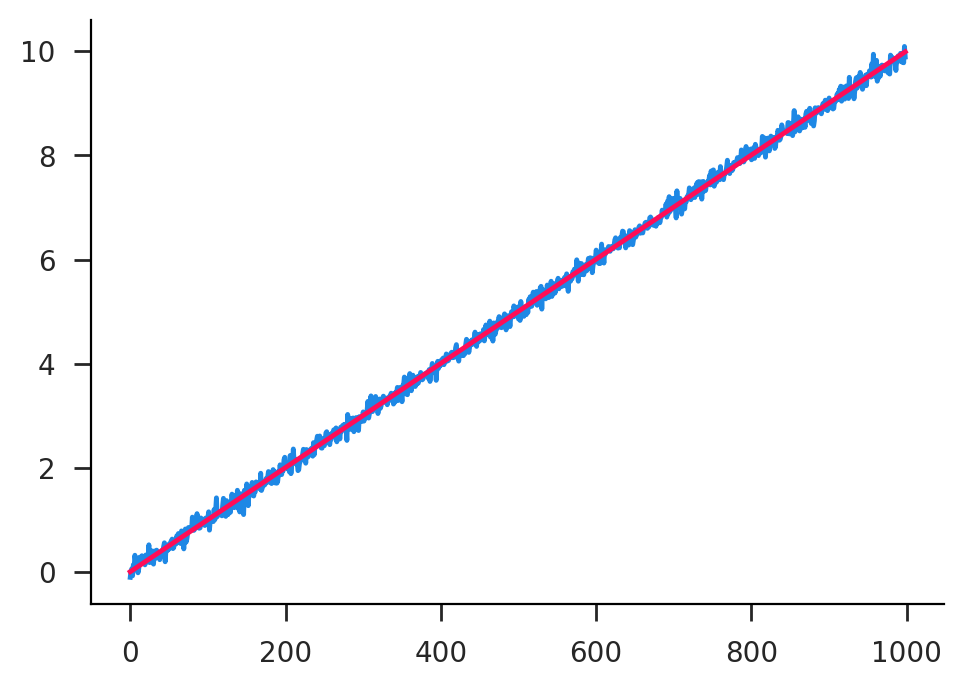

In [15]:
plt.plot(np.vstack([
    (regb.coef_[0]-1) + regb.coef_[11:],
    0.01*np.arange(1, 1000)
]).T);

## Generalized Linear Models (GLM)

Got integer or count data? Don't sacrifice your ideals! Run a Poisson regression. This is but one option in the broader class of GLM. These are models in which the outcome variable (`y`) follows a certain distribution (say a Poisson distribution), and the parameters of this distribution (say the Poisson rate) are linear functions (or non-linear functions of linear forms) of the exogenous (`X`) variables.

Let's use a handy routine from `fastreg` to generate some random Poisson data.

In [16]:
params = {'I': 0.1, 'x1': 0.3, 'x2': 0.6, 'id1': 1.0, 'id2': 1.0}
datap = fr.dataset(N=10_000, K1=10, K2=100, models='poisson', params=params)
datap.head(5)

,x1,x2,yhat0,yhat,id1,id2,Ep0,Ep,p0,p
0,-1.429225,-1.962930,-1.506526,-0.646526,E,46,0.221679,0.523863,0,0
1,0.687153,-0.284984,0.135155,0.205155,A,7,1.144715,1.227716,1,1
2,0.764353,0.448331,0.598304,1.268304,B,57,1.819032,3.554820,1,4
3,-0.309887,-1.149577,-0.682712,0.187288,H,17,0.505245,1.205974,0,1
4,-0.616042,0.430561,0.173524,0.203524,A,3,1.189489,1.225715,3,2


Next we'll use `fastreg` again to generate the design matrices. Note that we could also have used `formulaic` here.

In [17]:
ypn, yp, Xpn, Xp = fr.design_matrices(y=R.p, x=I + R.x1 + R.x2 + C.id1 + C.id2, data=datap)

Finally, let's run the Poisson estimation. Note that GLM estimation isn't quite as friendly and stable your typical OLS, as it's running some kind of maximum likelihood or moment routine in the background. For instance the below routine won't actually succeed unless you add in `alpha=1e-12`. The default of `alpha=0` leads to erroneous results.

In [18]:
regp = PoissonRegressor(fit_intercept=False, alpha=1e-12).fit(Xp, yp)
regp.coef_[:3]

array([0.07319317, 0.29713656, 0.59529798])

Here we can again check the fit on the larger categorical and see that it's pretty good, though noisier than the OLS results.

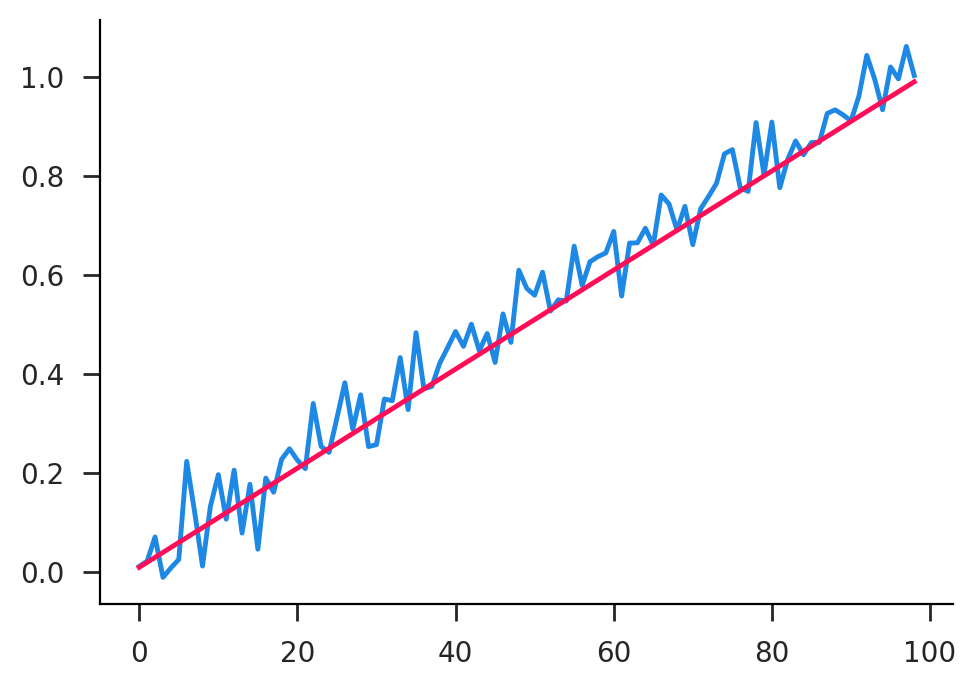

In [19]:
plt.plot(np.vstack([
    (regp.coef_[0]-params['I']) + regp.coef_[12:],
    (params['id2']/100)*np.arange(1, 100)
]).T);

We can also run a full Poisson regression with `fastreg` alone, though it uses a slower maximum likelihood routine.

In [20]:
retp = fr.general.poisson(y=R.p, x=I+R.x1+R.x2+C.id1+C.id2, data=datap)
coefI = retp.loc['I', 'coeff']
coef2 = retp.filter(regex='id2=\d+', axis=0)['coeff']

[  0] ℓ=-1.00000, g=2.84201, Δβ=0.05000, Δℓ=inf, μR=0.05000, μC=0.05000
[683] ℓ=2.47597, g=0.00005, Δβ=0.00010, Δℓ=0.00000, μR=0.32351, μC=0.51082


Here again the coefficients line up pretty well.

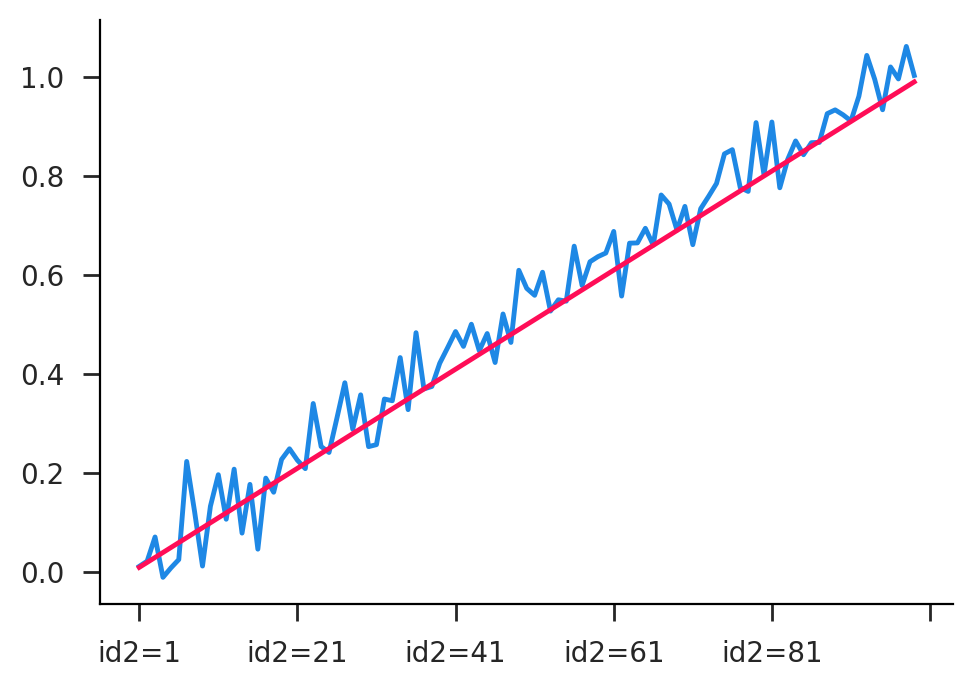

In [21]:
fig, ax = plt.subplots()
(coef2+(coefI-params['I'])).plot(ax=ax);
ax.plot((params['id2']/100)*np.arange(1, 100));

## K-means Clustering

Let's do a brief interlude on classification before we get into the heavier inference models. With K-means clustering, for a given integer value of $K$, we wish to find the $K$ centroids in a given space that minimize the mean-squared distance overall points to their nearest centroid. This is by far the most common spatial clustering technique. What we get out at the end is a list of centroids $c_k$, and an assignment of each point $x_i$ to their nearest centroid. The objective function for K-means is then

\\[
\min_{[c_k]_1^K} \sum_i \min_j \ (x_i-c_j)^2
\\]

The downside to K-means is that you have to pick $K$ in advance. You can fiddle around with different values, but there's not way to choose it automatically. Some other clustering algorithms go a bit in this direction, but there's no silver bullet.

Now let's generate some random clusters!

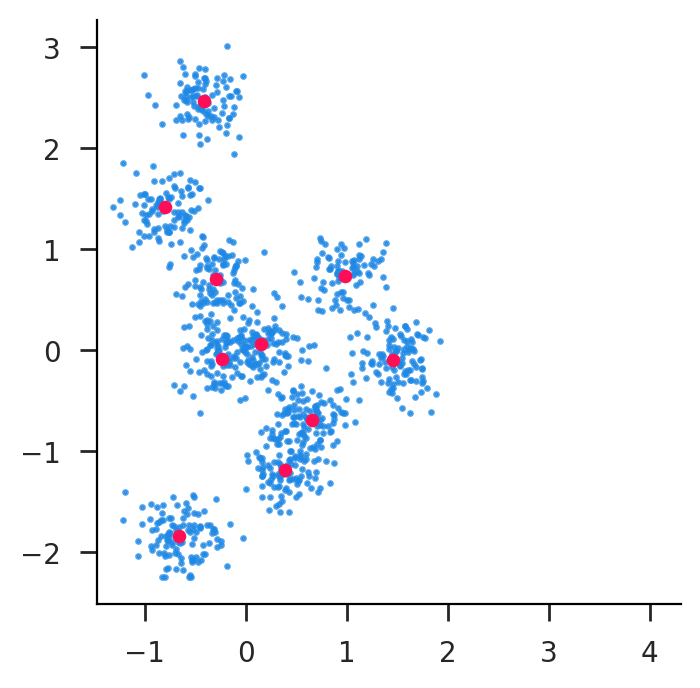

In [22]:
N, K = 1_000, 10
cent = np.random.normal(size=(K, 2))
grps = np.random.randint(K, size=N)
vals = cent[grps] + 0.2*np.random.normal(size=(N, 2))
fig, ax = plt.subplots()
ax.scatter(*vals.T, s=2, alpha=0.75)
ax.scatter(*cent.T, s=15)
ax.axis('square');

Running the estimation is pretty straightforward. There are number of runtime parameters that are listed in the `sklearn` documentation. Finally, we extract the estimated centroid locations and labels (which centroid each point is assigned to, integers from `0` to `K-1`).

In [23]:
retk = KMeans(n_clusters=K).fit(vals)
centk = retk.cluster_centers_
labsk = retk.labels_

Plotting the estimated labels, we can see that we did a pretty good job considering the level of overlap!

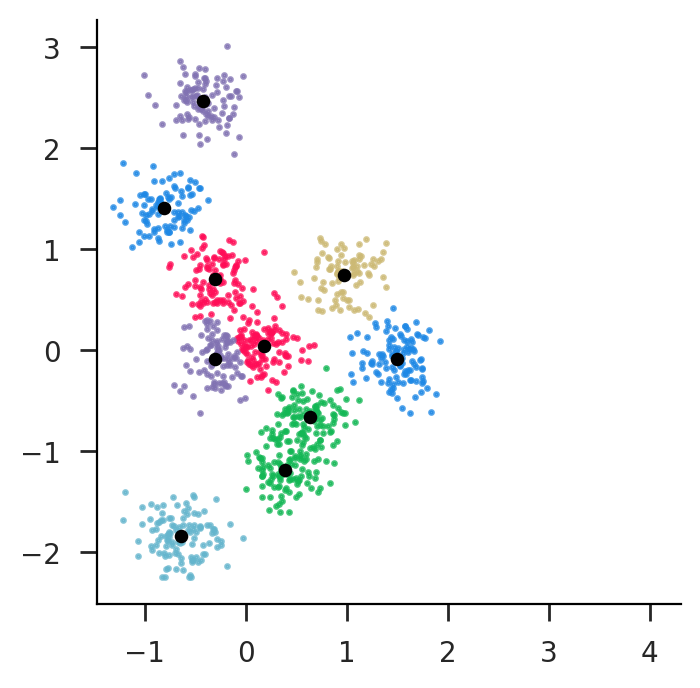

In [24]:
fig, ax = plt.subplots()
for k in range(K):
    ax.scatter(*vals[labsk==k].T, s=2, alpha=0.75)
ax.scatter(*centk.T, s=15, c='k')
ax.axis('square');

## Random Forest

Next we'll move on to some of the more advanced regression options. These start to tackle some of the issues of model selection. In the regular OLS world we just kind of choose our regressors and hope for the best. Handling things like non-linearities and interaction terms is up to our intuition. This more advanced set of estimators mostly uses decision trees and bootstrapping or model averaging to implicity do model selection and achieve much better prediction outcomes with minimal fine tuning. The cost is that they are much harder to interpret. You don't just get a regression coefficient that you can point to.

We need to make some data sufficiently complex to make the more advanced learning methods sweat a little bit. This would include things like non-linearities and interaction terms. Below, I'm putting in a cubic term in `x1` and an interaction term whereby the effect of `x2` is dependent on the value of the categorical `id1`.

In [25]:
Nrf = 5_000
datarf = pd.DataFrame({
    'x1': np.random.normal(size=Nrf),
    'x2': np.random.normal(size=Nrf),
    'id1': np.random.randint(10, size=Nrf)
})
poly = lambda x: x**3 - x**2
datarf['y'] = 1 + poly(datarf['x1']) + datarf['id1']*datarf['x2']
yrfn, yrf, Xrfn, Xrf = fr.design_matrices(y=R.y, x=I + R.x1 + R.x2 + C.id1, data=datarf)

Same basic routine for making design matrices. Note that we just put in the raw variables here, figuring out non-linearities and interactions is up to the estimator. Our main hyperparameter here is the `max_depth` option which determines the number of layers in the decision tree. Try playing around with different numbers to see how it does.

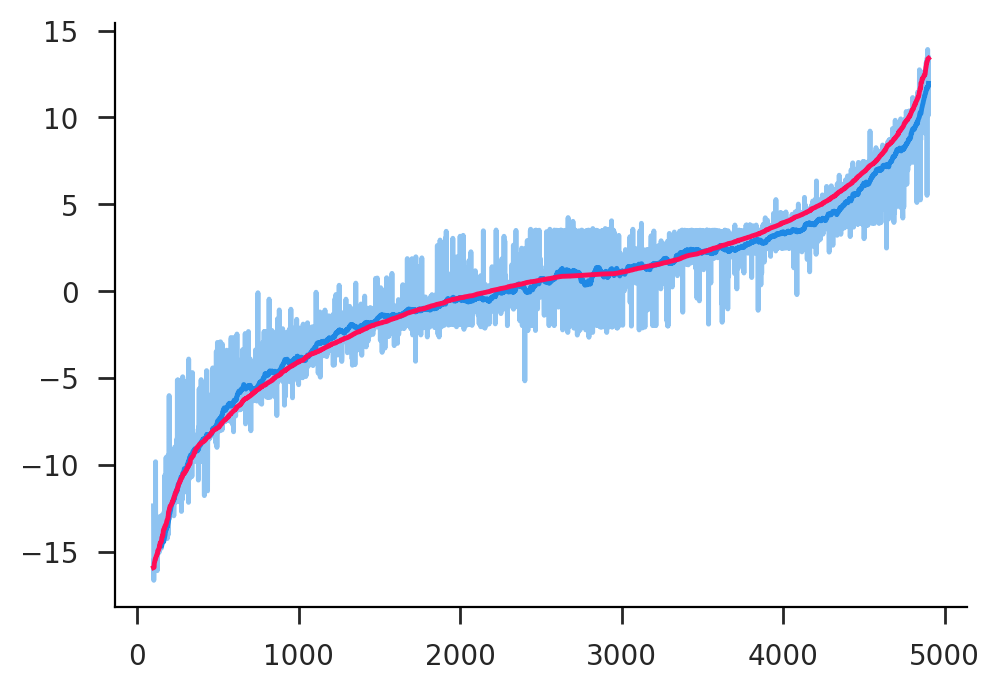

In [26]:
regrf = RandomForestRegressor(max_depth=10).fit(Xrf, yrf)
visual.plot_predict(datarf['y'], regrf.predict(Xrf), clip=100, smooth=50)

Now we can compare this to how a regular probably misspecified linear regression would do.

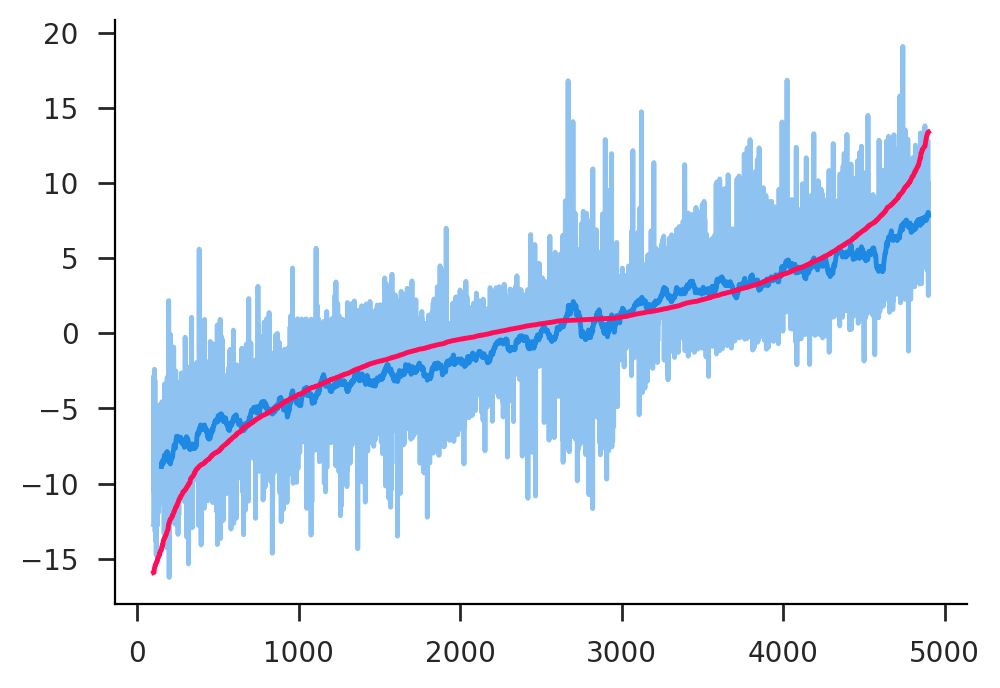

In [27]:
retrf1 = fr.ols(y=R.y, x=I+R.x1+R.x2+C.id1, data=datarf, output='dict')
visual.plot_predict(datarf['y'], retrf1['y_hat'], clip=100, smooth=50)

Okay, what if we magically knew the true underlying model? Well, then we can do really well!

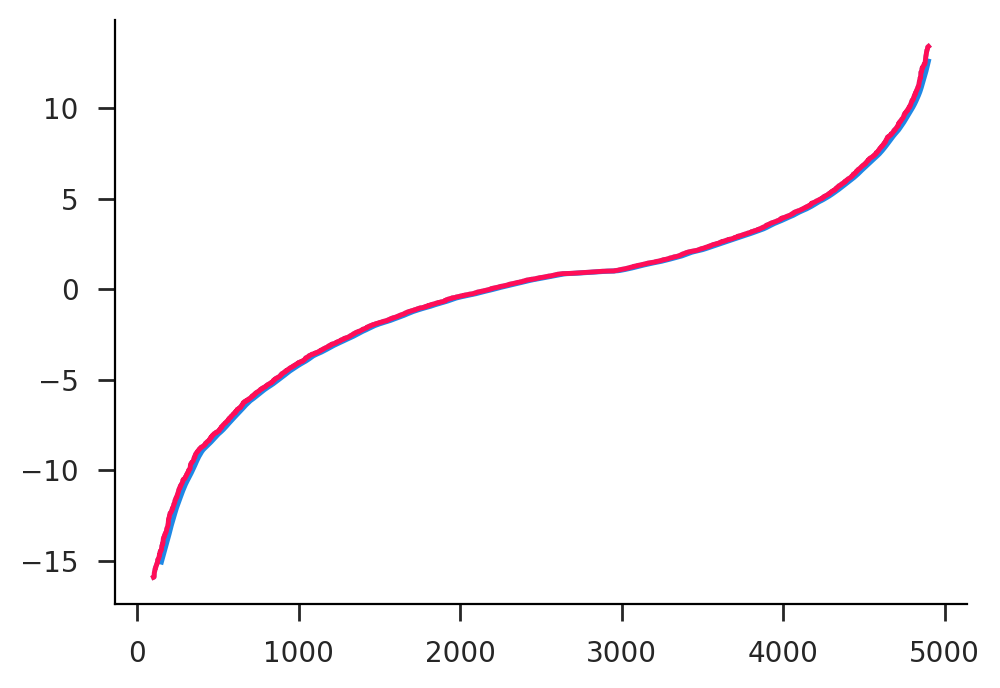

In [28]:
retrf2 = fr.ols(y=R.y, x=I+R('x1**2')+R('x1**3')+C.id1*R.x2, data=datarf, output='dict')
visual.plot_predict(datarf['y'], retrf2['y_hat'], clip=100, smooth=50)

## Gradient Boosting

Finally, we have gradient boosting. This achieves similar goals to a random forest, but can often achieve better prediction accuracy. Because it operates using decision trees (like random forest) it's sort dual use as both a classified and regressor. We can use the same data as before and check the observed fit. Looks pretty similar to random forest in this case.

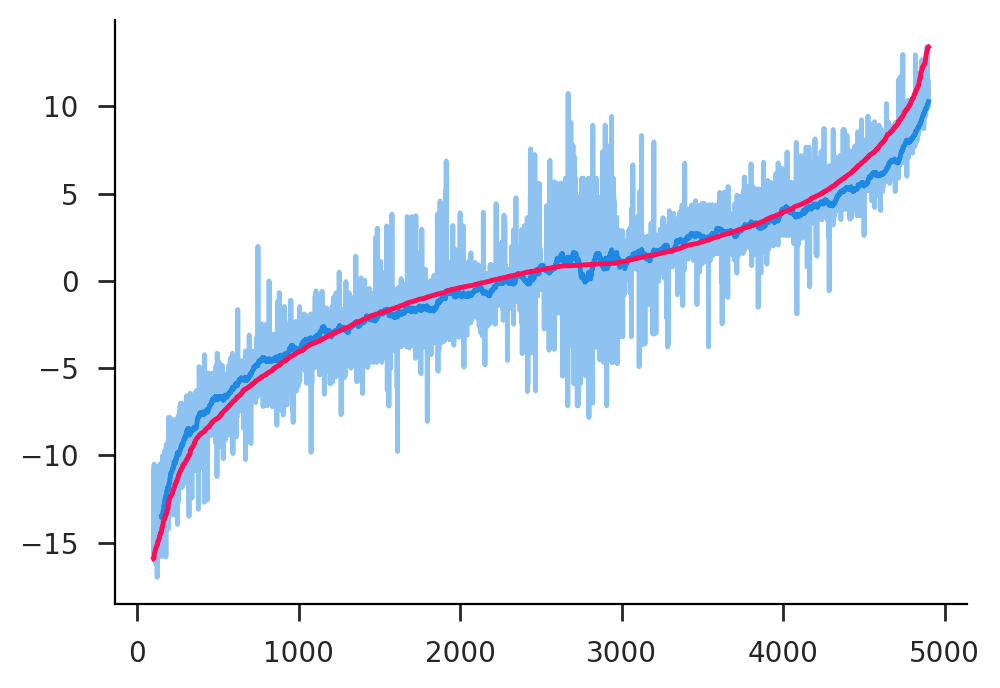

In [29]:
regrf = GradientBoostingRegressor().fit(Xrf, yrf)
visual.plot_predict(datarf['y'], regrf.predict(Xrf), clip=100, smooth=50)

There's another well known gradient boosting package called `xgboost` that is widely used in industry. This conveniently has the same interface type as an `sklearn` estimator. It has a ton of different options you can use, but below you can see that for the default options it does extremely well and is quite fast.

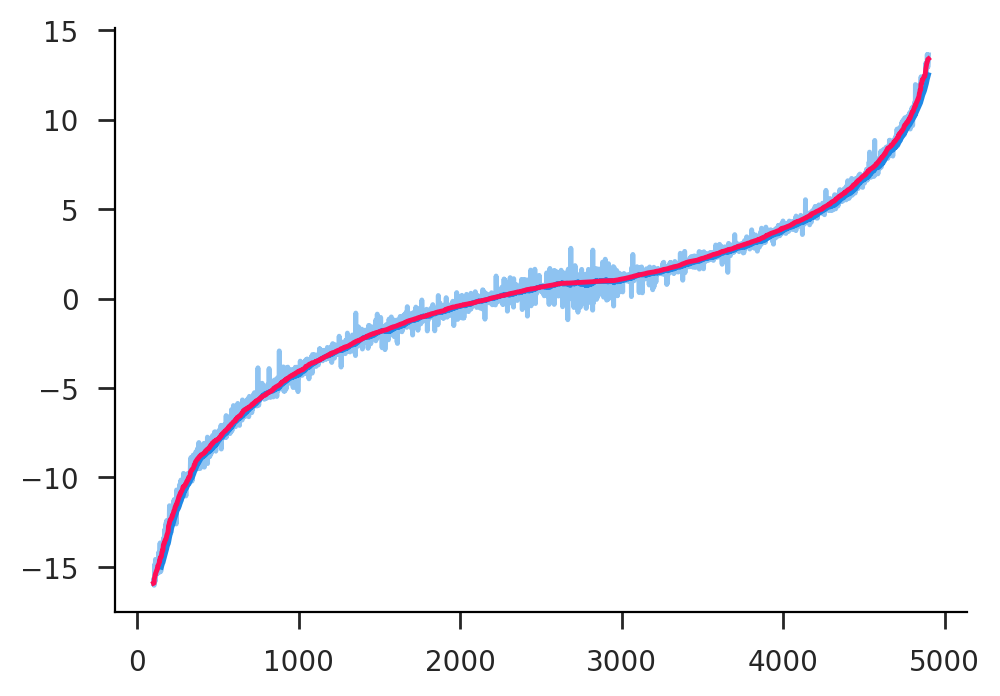

In [30]:
retxg = xgb.XGBRegressor().fit(Xrf, yrf)
visual.plot_predict(datarf['y'], retxg.predict(Xrf), clip=100, smooth=50)